In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
%matplotlib inline

In [16]:
def load_ipeds_unis(fname='../data/IPEDS/hd2020.csv', encoding='cp1252'):
    return pd.read_csv(fname, encoding=encoding)

def filter_only_rs_and_las(unis):
    unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
    unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')
    return unis

def preprocess_names(unis):
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
    unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
    unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
    return unis

def fetch_rankings(fname='../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                   usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'], top=-1):
    
    rankings = pd.read_excel(fname,skiprows=skiprows, usecols=usecols)
    
    if top > -1:
        rankings = rankings[rankings['Rank']<=top]
        
    return rankings

In [17]:
unis     = load_ipeds_unis()
unis     = filter_only_rs_and_las(unis)
unis     = preprocess_names(unis)

rankings = fetch_rankings(top=100)

merged   = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')

print("Missing unis: %s " % set(rankings['Institution Name']).difference(merged['INSTNM']))

/var/folders/wr/7qh9khyj6jn43plznhyqlm5h0000gn/T/ipykernel_97693/1318604980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')


Missing unis: set() 


In [31]:
unis2 = merged[['UNITID', 'INSTNM', 'Y', 'HBCU']]

In [80]:
results = {}
fnames = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
for i, fname in enumerate(fnames): 
    print("%s/%s - %s" % (i, len(fnames), fname))
    year = int(fname.split('/')[-1].split('_')[0][1:])
    
    if year in [2000, 2001]:
        continue
    
    data = pd.read_csv(fname)
    data.columns = [col.upper() for col in data.columns]
    data['CIPCODE_CAT'] = data['CIPCODE'].apply(math.floor)
    merged = pd.merge(data, unis2, on='UNITID')
    
    counts = merged.groupby(['Y', 'CIPCODE_CAT']).apply(lambda x: pd.Series(x['MAJORNUM'].value_counts())).reset_index()
    a = counts.pivot(index=['CIPCODE_CAT'], columns=['Y','level_2'], values='MAJORNUM').fillna(0)
    la_ratios = a['liberal_arts'][2]/a['liberal_arts'][1]
    r_ratios = a['research'][2]/a['research'][1]
    ratios = pd.concat([la_ratios, r_ratios], axis=1)
    ratios.columns = ['la_ratio', 'r_ratio']
    results[year] = ratios

0/21 - ../data/IPEDS/C2009_A/c2009_a_rv.csv
1/21 - ../data/IPEDS/C2007_A/c2007_a_rv.csv
2/21 - ../data/IPEDS/C2017_A/c2017_a_rv.csv
3/21 - ../data/IPEDS/C2013_A/c2013_a_rv.csv
4/21 - ../data/IPEDS/C2019_A/c2019_a_rv.csv
5/21 - ../data/IPEDS/C2004_A/c2004_a_rv.csv
6/21 - ../data/IPEDS/C2014_A/c2014_a_rv.csv
7/21 - ../data/IPEDS/C2010_A/c2010_a_rv.csv
8/21 - ../data/IPEDS/C2005_A/c2005_a_rv.csv
9/21 - ../data/IPEDS/C2015_A/c2015_a_rv.csv
10/21 - ../data/IPEDS/C2011_A/c2011_a_rv.csv
11/21 - ../data/IPEDS/C2008_A/c2008_a_rv.csv
12/21 - ../data/IPEDS/C2006_A/c2006_a_rv.csv
13/21 - ../data/IPEDS/C2016_A/c2016_a_rv.csv
14/21 - ../data/IPEDS/C2018_A/c2018_a_rv.csv
15/21 - ../data/IPEDS/C2012_A/c2012_a_rv.csv
16/21 - ../data/IPEDS/c2000_a.csv
17/21 - ../data/IPEDS/c2002_a.csv
18/21 - ../data/IPEDS/c2020_a.csv
19/21 - ../data/IPEDS/c2003_a.csv
20/21 - ../data/IPEDS/c2001_a.csv


In [83]:
years_sorted = sorted(list(results.keys()))

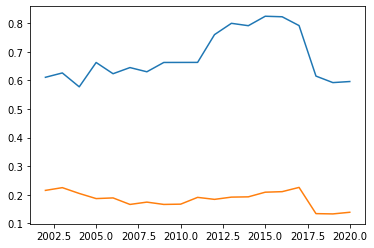

In [90]:
la_results = pd.Series([results[year]['la_ratio'].loc[11] for year in years_sorted], index=years_sorted)
r_results  = pd.Series([results[year]['r_ratio'].loc[11] for year in years_sorted], index=years_sorted)
plt.plot(la_results)
plt.plot(r_results)

In [25]:
majornum_counts = data.groupby('CIPCODE_CAT').apply(lambda x: x.value_counts('MAJORNUM'))

In [27]:
majornum_counts['ratio'] = majornum_counts[2]/majornum_counts[1] 